### Import libraries

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deepgaze2e.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=['img', 'sp_idx'])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

In [3]:
# Computing the correlation matrix
corr_matrix = df[num_cols].corr()

# Find pairs with correlation >= 0.8
high_corr_pairs = np.column_stack(
    np.where((np.abs(corr_matrix) >= 0.8) & (corr_matrix != 1))
)
high_corr_cols = []

# Extracting and printing the pairs
seen_pairs = set()
for i, j in high_corr_pairs:
    col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
    if (col2, col1) not in seen_pairs:
        print(
            f"Correlation between {col1} and {col2} is {round(corr_matrix.iloc[i, j], 3)}"
        )
        seen_pairs.add((col1, col2))
        seen_pairs.add((col2, col1))
        high_corr_cols.append(col1)
        high_corr_cols.append(col2)

Correlation between sp_fix_count and sp_len_px_total is 0.801
Correlation between sp_fix_duration_ms_total and sal_weighted_duration_sum is 0.812
Correlation between sp_fix_duration_ms_mean and sal_weighted_duration_mean is 0.813
Correlation between sal_first_above_0.75*max_rank and sal_max is -0.802
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.8
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.819
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.874


### further processing

... drop more columns, create new ones, handle highly correlating columns.....

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [4]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '7098' samples & '33' features
test-set has '500' samples - out of '7598'
  ~ 6.58% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [5]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

---
## Model - Preparations

### Column Transformers for Data Preproccessing
these are only used for certain Models, which we expect to perform better with Preproccessed Data

In [6]:
# add other transformations at the end if needed
transformer = [("scaler", MinMaxScaler(), num_cols),
               ("ohe", OneHotEncoder(drop="first"), cat_cols  )]
               
preprocessing = ColumnTransformer(transformer,
                                  remainder="passthrough")

###  Pipelines for each Model

In [7]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([
    ("classifier", RandomForestClassifier())
])

# XGBoost: apply scaling / encoding
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", XGBClassifier())
])

# Support Vector Classifier: apply scaling / encoding
svc_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier",SVC())
])

# Logistic Regression: apply scaling / encoding
log_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", LogisticRegression(max_iter=1000))
])

### Parameter Grids

In [8]:
# Random Forest
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

# XGBoost
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__learning_rate": [0.1, 0.01, 0.001]
}

# Support Vector Classifier
param_grid_svc = {
    'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel types to try
    'classifier__C': [0.1, 1, 10, 100],  # Regularization parameter values
    'classifier__gamma': ['scale', 'auto'],  # Gamma parameter for RBF kernel
    'classifier__degree': [2, 3, 4]  # Degree of the polynomial kernel (only for poly kernel)
}

# Logistic Regression
param_grid_logreg = {
    'classifier__penalty': ['l1', 'l2'],  # Penalty type: l1 (Lasso) or l2 (Ridge)
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]  # Regularization strength
}

---
## Modeling

### Random Forest

In [9]:
# Create GridSearchCV object
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=cv,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_est_rf = grid_search_rf.best_estimator_
print("Best params for RF are:", best_params_rf)
print("Best est for RF are:", best_est_rf)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


/Users/azabicki/miniconda3/envs/nf_CAPSTONE/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/Users/azabicki/miniconda3/envs/nf_CAPSTONE/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best params for RF are: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best est for RF are: Pipeline(steps=[('classifier',
                 RandomForestClassifier(min_samples_leaf=4,
                                        min_samples_split=10,
                                        n_estimators=200))])


In [10]:
# predict & proba
pred_test = grid_search_rf.predict(X_test)
proba_test = grid_search_rf.predict_proba(X_test)

pred_train = grid_search_rf.predict(X_train)
proba_train = grid_search_rf.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.940     0.943     0.941      3579
           1      0.942     0.939     0.940      3519

    accuracy                          0.941      7098
   macro avg      0.941     0.941     0.941      7098
weighted avg      0.941     0.941     0.941      7098

f(0.5)-score: 0.941
f(2.0)-score: 0.939

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.697     0.721     0.709       258
           1      0.691     0.665     0.678       242

    accuracy                          0.694       500
   macro avg      0.694     0.693     0.693       500
weighted avg      0.694     0.694     0.694       500

f(0.5)-score: 0.686
f(2.0)-score: 0.670



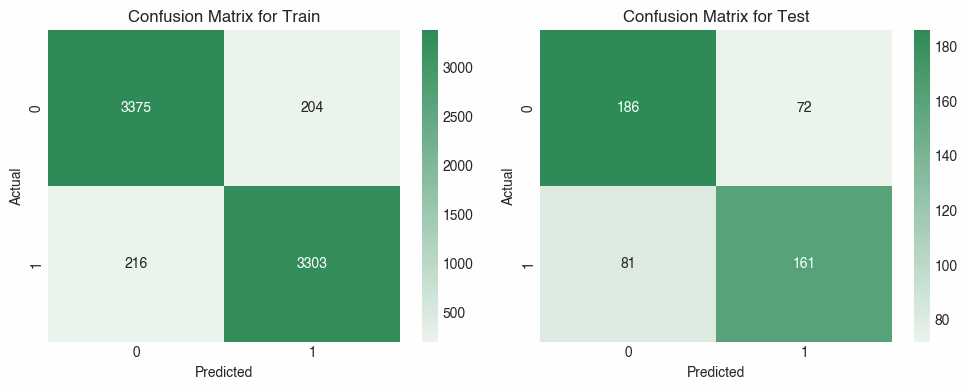

------------------------------------------------------------
'Train': ROC AUC score = 0.941
'Test': ROC AUC score = 0.693


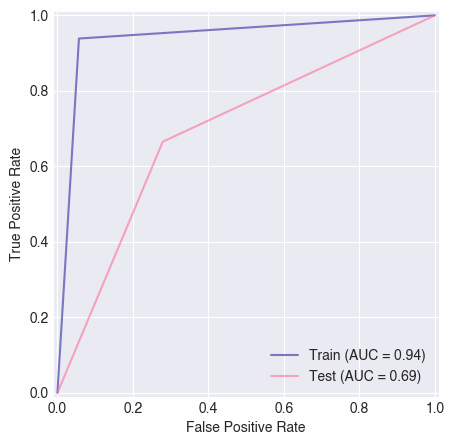

In [11]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

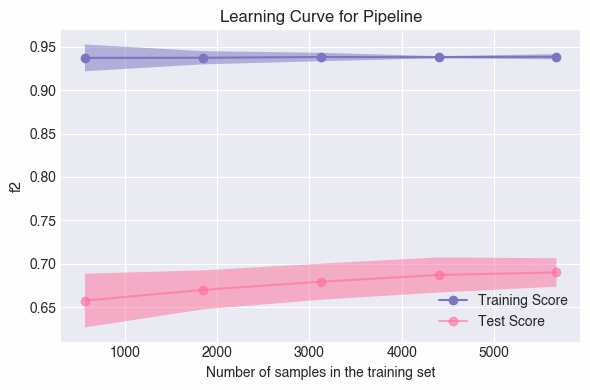

In [12]:
# learning curves - for one model - f2 score
em.learning(best_est_rf, X_train, y_train)

In [13]:
em.model_info(best_est_rf)